## Backtest Strategy Playground

Notebook ini dipakai untuk mencoba berbagai strategy dari folder `src/strategy_backtest/strategies`.
Ganti nilai `STRATEGY_NAME` pada sel konfigurasi untuk memanggil file strategy yang berbeda.

In [1]:
from __future__ import annotations

import io
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import get_ipython
from IPython.display import Image, display
from qf_lib.analysis.timeseries_analysis.timeseries_analysis import TimeseriesAnalysis
from qf_lib.common.enums.frequency import Frequency
from qf_lib.containers.series.simple_returns_series import SimpleReturnsSeries

PROJECT_ROOT = Path('..').resolve()
for path in (PROJECT_ROOT, PROJECT_ROOT / 'src'):
    if str(path) not in sys.path:
        sys.path.append(str(path))

_ip = get_ipython()
if _ip is not None:
    try:
        _ip.run_line_magic('matplotlib', 'inline')
    except AttributeError:
        plt.switch_backend('Agg')
else:
    plt.switch_backend('Agg')

warnings.filterwarnings('ignore', category=FutureWarning, module='qf_lib')

plt.style.use('seaborn-v0_8-darkgrid')

from src.strategy_backtest import (
    SignalBacktester,
    get_strategy,
    list_strategies,
    load_strategy_csv,
)


In [2]:
# Konfigurasi dataset & strategy
DATA_FILE = PROJECT_ROOT / 'data' / 'OKX_ETHUSDT.P, 1D.csv'
TIME_COLUMN = 'time'
PRICE_COLUMN = 'close'
ASSET_SYMBOL = 'ETHUSDT'

# Ganti nama strategy sesuai file di `src/strategy_backtest/strategies/`
STRATEGY_NAME = 'vwap'
# Opsional: override parameter default strategy
STRATEGY_PARAMS = {}

In [3]:
data, column_mapping = load_strategy_csv(DATA_FILE, time_column=TIME_COLUMN)
print(f'Dataset berisi {len(data):,} bar dengan {len(data.columns)} kolom.')
print('Contoh mapping kolom (sanitised -> original):')
for alias, original in list(column_mapping.items())[:10]:
    print(f'  {alias} -> {original}')

display(data.head())

Dataset berisi 2,152 bar dengan 35 kolom.
Contoh mapping kolom (sanitised -> original):
  time -> time
  open -> open
  high -> high
  low -> low
  close -> close
  volume -> Volume
  vwap -> VWAP
  vwap_1 -> VWAP.1
  ema -> EMA
  lucid_connector -> LUCID Connector


,open,high,low,close,volume,vwap,vwap_1,ema,lucid_connector,hyperwave,...,upper_confluence_zone,lower_confluence_zone,confluence_meter_value,custom_alert_condition_highlighter,alert_scripting_condition_highlighter,at_valuewhen,atr,histogram,macd,signal
time,,,,,,,,,,,,,,,,,,,,,
2019-12-25,127.64,127.72,123.40,125.07,2.193667e+06,125.396667,125.396667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,125.07,132.00,124.37,125.61,3.770336e+06,127.326667,127.326667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,125.66,126.96,122.65,126.26,5.765802e+06,125.290000,125.290000,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-28,126.24,129.68,125.86,128.09,6.235318e+06,127.876667,127.876667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,128.08,137.97,127.57,134.26,6.826287e+06,133.266667,133.266667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
available = list_strategies()
print('Strategi tersedia:', ', '.join(available))
strategy = get_strategy(STRATEGY_NAME, **STRATEGY_PARAMS)
print('Deskripsi strategi:')
print(f"- Nama: {strategy.metadata.name}")
print(f"- Deskripsi: {strategy.metadata.description}")
print(f"- Entry: {strategy.metadata.entry}")
print(f"- Exit: {strategy.metadata.exit}")
print('Parameter default:')
for key, value in strategy.metadata.parameters.items():
    print(f'  {key}: {value}')
if not strategy.metadata.parameters:
    print('  (tidak ada parameter default eksplisit)')
print('Parameter aktif:')
for key, value in strategy.params.items():
    print(f'  {key}: {value}')
if not strategy.params:
    print('  (menggunakan nilai default)')

signals = strategy.generate_signals(data)
print('Kolom sinyal:', list(signals.columns))
display(signals.head())

Strategi tersedia: ema112_atr, vwap
Deskripsi strategi:
- Nama: vwap
- Deskripsi: Strategi VWAP mean reversion: beli ketika harga di bawah VWAP dengan RSI rebound bullish, jual ketika harga di atas VWAP dengan RSI bearish dari area jenuh beli.
- Entry: Long: harga penutupan di bawah VWAP, RSI sebelumnya berada di bawah level oversold lalu menembus ke atas level 50. Short: harga penutupan di atas VWAP, RSI sebelumnya berada di atas level overbought lalu menembus ke bawah level 50.
- Exit: Stop loss berbasis ATR yang dieksekusi pada penembusan high/low harian ditambah trailing stop opsional.
Parameter default:
  rsi_length: 14
  rsi_overbought: 60
  rsi_oversold: 40
  atr_length: 14
  atr_stop_multiplier: 1.5
  session_frequency: 1D
  trail_activation_multiple: 1.0
  trail_atr_multiplier: 1.0
Parameter aktif:
  rsi_length: 14
  rsi_overbought: 70
  rsi_oversold: 30
  atr_length: 14
  atr_stop_multiplier: 1.5
  session_frequency: 1D
  trail_activation_multiple: 1.0
  trail_atr_multiplier:

,long_entry,long_exit,short_entry,short_exit,vwap,rsi,atr,active_entry_price,stop_level,position,best_price,trail_active
time,,,,,,,,,,,,
2019-12-25,False,False,False,False,125.396667,NaN,4.320000,NaN,NaN,flat,NaN,False
2019-12-26,False,False,False,False,127.326667,NaN,4.556429,NaN,NaN,flat,NaN,False
2019-12-27,False,False,False,False,125.290000,NaN,4.538827,NaN,NaN,flat,NaN,False
2019-12-28,False,False,False,False,127.876667,NaN,4.487482,NaN,NaN,flat,NaN,False
2019-12-29,False,False,False,False,133.266667,NaN,4.909805,NaN,NaN,flat,NaN,False


In [5]:
backtester = SignalBacktester(data=data, price_column=PRICE_COLUMN)
outputs = backtester.run(signals)

metrics_series = pd.Series(outputs.metrics, name='value')
trade_summary_series = pd.Series(outputs.trade_summary, name='value')

trade_summary_order = [
    'total_trades', 'long_trades', 'short_trades',
    'winning_trades', 'losing_trades', 'breakeven_trades',
    'win_rate', 'loss_rate', 'breakeven_rate',
    'avg_pnl_pct', 'avg_pnl_currency', 'median_pnl_pct',
    'net_profit_pct', 'net_profit_currency',
    'gross_profit_pct', 'gross_loss_pct', 'profit_factor_pct',
    'gross_profit_currency', 'gross_loss_currency', 'profit_factor_currency',
    'avg_win_pct', 'avg_loss_pct', 'avg_win_currency', 'avg_loss_currency',
    'avg_bars', 'median_bars', 'avg_bars_winning', 'avg_bars_losing',
    'max_consecutive_wins', 'max_consecutive_losses',
    'time_in_market_pct', 'long_exposure_pct', 'short_exposure_pct',
    'avg_position', 'avg_abs_position',
    'best_trade_pct', 'worst_trade_pct', 'best_trade_currency', 'worst_trade_currency',
]
ordered_keys = [key for key in trade_summary_order if key in trade_summary_series.index]
remaining_keys = [key for key in trade_summary_series.index if key not in ordered_keys]
ordered_trade_summary = trade_summary_series.loc[ordered_keys + remaining_keys]

print('Metrik performa:')
display(metrics_series.to_frame().style.format({'value': '{:.4f}'}))

print('Ringkasan trade:')
display(ordered_trade_summary.to_frame().style.format({'value': '{:.4f}'}))

summary_lines = []
total_trades = trade_summary_series.get('total_trades')
if pd.notna(total_trades):
    summary_lines.append(f"Total trade dieksekusi: {int(total_trades)}")

winning_trades = trade_summary_series.get('winning_trades')
win_rate = trade_summary_series.get('win_rate')
if pd.notna(winning_trades) and pd.notna(win_rate):
    summary_lines.append(f"Menang: {int(winning_trades)} ({win_rate:.2%})")

losing_trades = trade_summary_series.get('losing_trades')
loss_rate = trade_summary_series.get('loss_rate')
if pd.notna(losing_trades) and pd.notna(loss_rate):
    summary_lines.append(f"Kalah: {int(losing_trades)} ({loss_rate:.2%})")

breakeven_trades = trade_summary_series.get('breakeven_trades')
breakeven_rate = trade_summary_series.get('breakeven_rate')
if pd.notna(breakeven_trades) and pd.notna(breakeven_rate):
    summary_lines.append(f"Break-even: {int(breakeven_trades)} ({breakeven_rate:.2%})")

net_profit_pct = trade_summary_series.get('net_profit_pct')
net_profit_currency = trade_summary_series.get('net_profit_currency')
if pd.notna(net_profit_pct):
    summary_lines.append(f"Akumulasi PnL %: {net_profit_pct:.2%}")
if pd.notna(net_profit_currency):
    summary_lines.append(f"Akumulasi PnL nominal: {net_profit_currency:,.2f}")

profit_factor_currency = trade_summary_series.get('profit_factor_currency')
if pd.notna(profit_factor_currency):
    summary_lines.append(f"Profit factor (nominal): {profit_factor_currency:.2f}")

profit_factor_pct = trade_summary_series.get('profit_factor_pct')
if pd.notna(profit_factor_pct):
    summary_lines.append(f"Profit factor (persentase): {profit_factor_pct:.2f}")

time_in_market = trade_summary_series.get('time_in_market_pct')
if pd.notna(time_in_market):
    summary_lines.append(f"Waktu terpapar pasar: {time_in_market:.2%}")

long_exposure = trade_summary_series.get('long_exposure_pct')
short_exposure = trade_summary_series.get('short_exposure_pct')
if pd.notna(long_exposure) and pd.notna(short_exposure):
    summary_lines.append(f"Proporsi bar long/short: {long_exposure:.2%} long / {short_exposure:.2%} short")

avg_bars = trade_summary_series.get('avg_bars')
if pd.notna(avg_bars):
    summary_lines.append(f"Rata-rata durasi trade: {avg_bars:.2f} bar")

avg_win_pct = trade_summary_series.get('avg_win_pct')
avg_loss_pct = trade_summary_series.get('avg_loss_pct')
if pd.notna(avg_win_pct) and pd.notna(avg_loss_pct):
    summary_lines.append(f"Rata-rata %PnL menang/kalah: {avg_win_pct:.2%} / {avg_loss_pct:.2%}")

max_win = trade_summary_series.get('best_trade_pct')
max_loss = trade_summary_series.get('worst_trade_pct')
if pd.notna(max_win) and pd.notna(max_loss):
    summary_lines.append(f"Trade terbaik/terburuk (%): {max_win:.2%} / {max_loss:.2%}")

if summary_lines:
    print('Ikhtisar singkat:')
    for line in summary_lines:
        print(f'  - {line}')

position_counts = outputs.positions.value_counts().rename('bars').sort_index()
if not position_counts.empty:
    position_summary = pd.DataFrame({'bars': position_counts})
    position_summary['percentage'] = position_summary['bars'] / len(outputs.positions)
    position_summary.index.name = 'position'
    print('Distribusi posisi berdasarkan jumlah bar:')
    display(position_summary.style.format({'bars': '{:,.0f}', 'percentage': '{:.2%}'}))

print(f'Log trade lengkap ({len(outputs.trades)} baris):')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(outputs.trades)

if not outputs.trades.empty:
    trade_columns = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'entry_price', 'exit_price',
        'pnl_pct', 'pnl_currency', 'bars_held', 'exit_reason',
    ]
    available_columns = [col for col in trade_columns if col in outputs.trades.columns]
    print('Top 5 trade terbaik berdasarkan % PnL:')
    display(outputs.trades.nlargest(5, 'pnl_pct')[available_columns])
    print('Top 5 trade terburuk berdasarkan % PnL:')
    display(outputs.trades.nsmallest(5, 'pnl_pct')[available_columns])


Metrik performa:


,value
total_return,0.0000
cagr,0.0000
sharpe_ratio,nan
annualised_vol,0.0000
max_drawdown,0.0000
avg_drawdown_duration,0.0000


Ringkasan trade:


,value
total_trades,0.0000
long_trades,0.0000
short_trades,0.0000
winning_trades,0.0000
losing_trades,0.0000
breakeven_trades,0.0000
win_rate,nan
loss_rate,nan
breakeven_rate,nan
avg_pnl_pct,nan


Ikhtisar singkat:
  - Total trade dieksekusi: 0
  - Waktu terpapar pasar: 0.00%
  - Proporsi bar long/short: 0.00% long / 0.00% short
Distribusi posisi berdasarkan jumlah bar:


,bars,percentage
position,,
0.000000,"2,152",100.00%


Log trade lengkap (0 baris):


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason


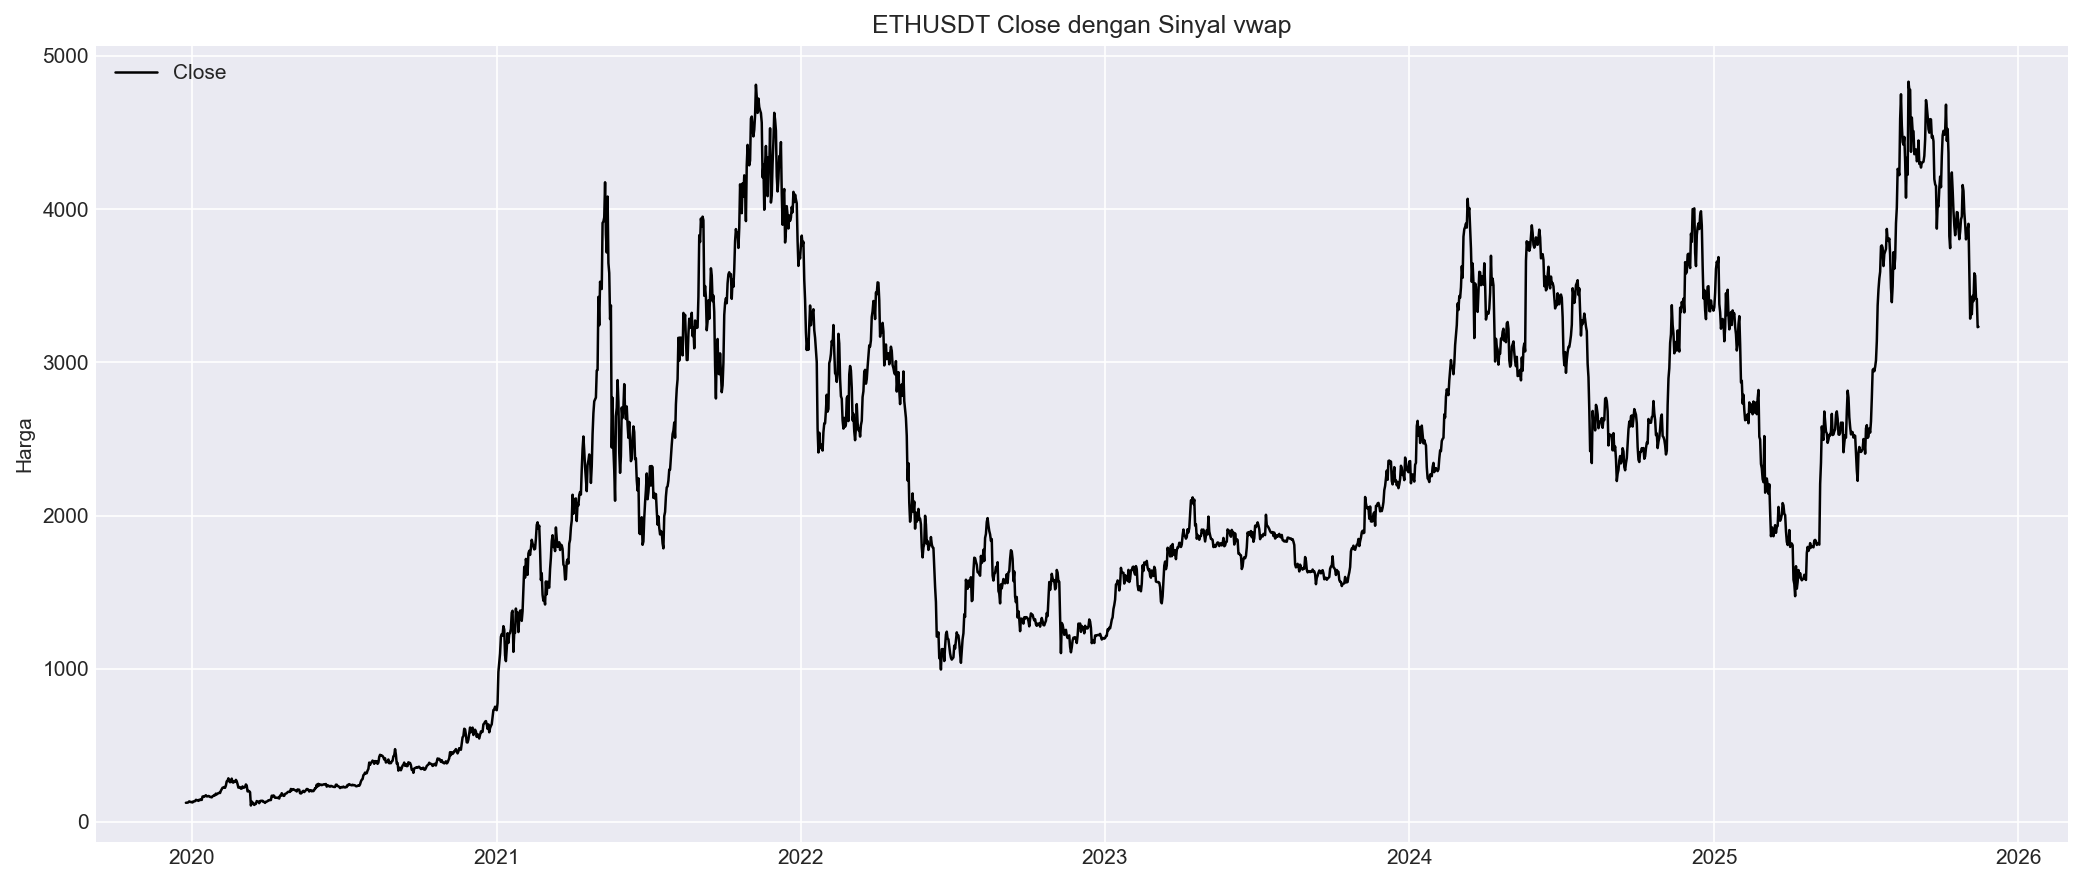

In [6]:
def _as_bool(series: pd.Series | None) -> pd.Series:
    if series is None:
        return pd.Series(False, index=data.index)
    aligned = series.reindex(data.index)
    return aligned.fillna(False).astype(bool)

close_prices = data[PRICE_COLUMN]
long_entries = _as_bool(signals.get('long_entry'))
long_exits = _as_bool(signals.get('long_exit'))
short_entries = _as_bool(signals.get('short_entry'))
short_exits = _as_bool(signals.get('short_exit'))

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(close_prices.index, close_prices, label='Close', color='black', linewidth=1.2)

if long_entries.any():
    ax.scatter(close_prices.index[long_entries], close_prices[long_entries], marker='^', color='green', label='Long Entry', zorder=5)
if short_entries.any():
    ax.scatter(close_prices.index[short_entries], close_prices[short_entries], marker='v', color='red', label='Short Entry', zorder=5)
if long_exits.any():
    ax.scatter(close_prices.index[long_exits], close_prices[long_exits], marker='v', color='tab:blue', label='Long Exit', zorder=6)
if short_exits.any():
    ax.scatter(close_prices.index[short_exits], close_prices[short_exits], marker='^', color='tab:orange', label='Short Exit', zorder=6)

ax.set_title(f'{ASSET_SYMBOL} Close dengan Sinyal {STRATEGY_NAME}')
ax.set_ylabel('Harga')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()

buffer = io.BytesIO()
fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
buffer.seek(0)
display(Image(data=buffer.read()))
plt.close(fig)


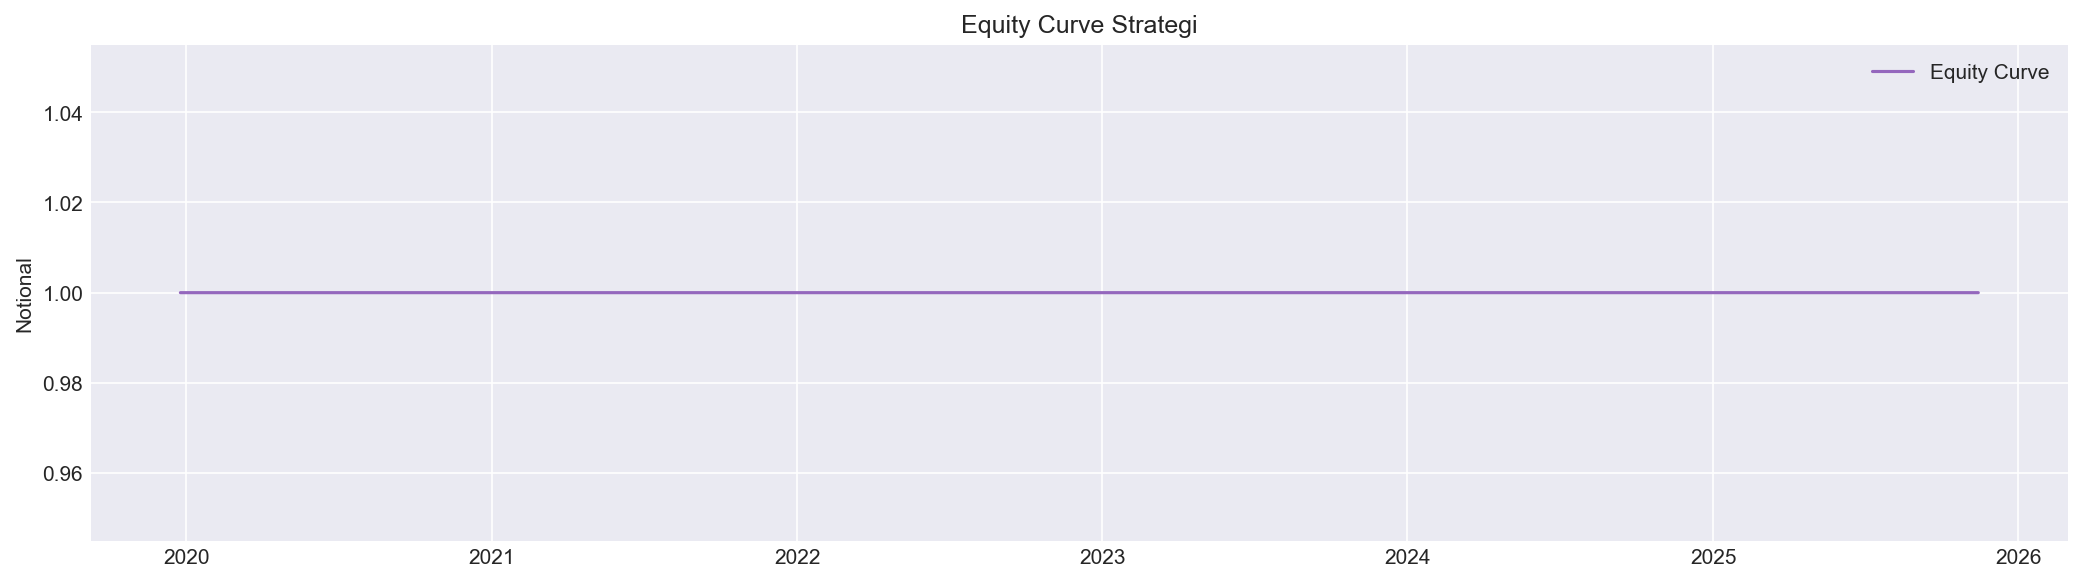

Metrik performa:


,value
total_return,0.0000
cagr,0.0000
sharpe_ratio,nan
annualised_vol,0.0000
max_drawdown,0.0000
avg_drawdown_duration,0.0000


Ringkasan trade:


,value
total_trades,0.0000
long_trades,0.0000
short_trades,0.0000
winning_trades,0.0000
losing_trades,0.0000
breakeven_trades,0.0000
win_rate,nan
loss_rate,nan
breakeven_rate,nan
avg_pnl_pct,nan


Ikhtisar singkat:
  - Total trade dieksekusi: 0
  - Waktu terpapar pasar: 0.00%
  - Proporsi bar long/short: 0.00% long / 0.00% short
Distribusi posisi berdasarkan jumlah bar:


,bars,percentage
position,,
0.000000,"2,152",100.00%


Log trade lengkap (0 baris):


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason


In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(outputs.results.index, outputs.results['equity_curve'], color='C4', label='Equity Curve')
ax.set_title('Equity Curve Strategi')
ax.set_ylabel('Notional')
ax.legend()
fig.tight_layout()

plot_buffer = io.BytesIO()
fig.savefig(plot_buffer, format='png', dpi=150, bbox_inches='tight')
plot_buffer.seek(0)
display(Image(data=plot_buffer.read()))
plt.close(fig)

trade_summary_order = [
    'total_trades', 'long_trades', 'short_trades',
    'winning_trades', 'losing_trades', 'breakeven_trades',
    'win_rate', 'loss_rate', 'breakeven_rate',
    'avg_pnl_pct', 'avg_pnl_currency', 'median_pnl_pct',
    'net_profit_pct', 'net_profit_currency',
    'gross_profit_pct', 'gross_loss_pct', 'profit_factor_pct',
    'gross_profit_currency', 'gross_loss_currency', 'profit_factor_currency',
    'avg_win_pct', 'avg_loss_pct', 'avg_win_currency', 'avg_loss_currency',
    'avg_bars', 'median_bars', 'avg_bars_winning', 'avg_bars_losing',
    'max_consecutive_wins', 'max_consecutive_losses',
    'time_in_market_pct', 'long_exposure_pct', 'short_exposure_pct',
    'avg_position', 'avg_abs_position',
    'best_trade_pct', 'worst_trade_pct', 'best_trade_currency', 'worst_trade_currency',
]
ordered_keys = [key for key in trade_summary_order if key in trade_summary_series.index]
remaining_keys = [key for key in trade_summary_series.index if key not in ordered_keys]
ordered_trade_summary = trade_summary_series.loc[ordered_keys + remaining_keys]

print('Metrik performa:')
display(metrics_series.to_frame().style.format({'value': '{:.4f}'}))

print('Ringkasan trade:')
display(ordered_trade_summary.to_frame().style.format({'value': '{:.4f}'}))

summary_lines = []
total_trades = trade_summary_series.get('total_trades')
if pd.notna(total_trades):
    summary_lines.append(f"Total trade dieksekusi: {int(total_trades)}")

winning_trades = trade_summary_series.get('winning_trades')
win_rate = trade_summary_series.get('win_rate')
if pd.notna(winning_trades) and pd.notna(win_rate):
    summary_lines.append(f"Menang: {int(winning_trades)} ({win_rate:.2%})")

losing_trades = trade_summary_series.get('losing_trades')
loss_rate = trade_summary_series.get('loss_rate')
if pd.notna(losing_trades) and pd.notna(loss_rate):
    summary_lines.append(f"Kalah: {int(losing_trades)} ({loss_rate:.2%})")

breakeven_trades = trade_summary_series.get('breakeven_trades')
breakeven_rate = trade_summary_series.get('breakeven_rate')
if pd.notna(breakeven_trades) and pd.notna(breakeven_rate):
    summary_lines.append(f"Break-even: {int(breakeven_trades)} ({breakeven_rate:.2%})")

net_profit_pct = trade_summary_series.get('net_profit_pct')
net_profit_currency = trade_summary_series.get('net_profit_currency')
if pd.notna(net_profit_pct):
    summary_lines.append(f"Akumulasi PnL %: {net_profit_pct:.2%}")
if pd.notna(net_profit_currency):
    summary_lines.append(f"Akumulasi PnL nominal: {net_profit_currency:,.2f}")

profit_factor_currency = trade_summary_series.get('profit_factor_currency')
if pd.notna(profit_factor_currency):
    summary_lines.append(f"Profit factor (nominal): {profit_factor_currency:.2f}")

profit_factor_pct = trade_summary_series.get('profit_factor_pct')
if pd.notna(profit_factor_pct):
    summary_lines.append(f"Profit factor (persentase): {profit_factor_pct:.2f}")

time_in_market = trade_summary_series.get('time_in_market_pct')
if pd.notna(time_in_market):
    summary_lines.append(f"Waktu terpapar pasar: {time_in_market:.2%}")

long_exposure = trade_summary_series.get('long_exposure_pct')
short_exposure = trade_summary_series.get('short_exposure_pct')
if pd.notna(long_exposure) and pd.notna(short_exposure):
    summary_lines.append(f"Proporsi bar long/short: {long_exposure:.2%} long / {short_exposure:.2%} short")

avg_bars = trade_summary_series.get('avg_bars')
if pd.notna(avg_bars):
    summary_lines.append(f"Rata-rata durasi trade: {avg_bars:.2f} bar")

avg_win_pct = trade_summary_series.get('avg_win_pct')
avg_loss_pct = trade_summary_series.get('avg_loss_pct')
if pd.notna(avg_win_pct) and pd.notna(avg_loss_pct):
    summary_lines.append(f"Rata-rata %PnL menang/kalah: {avg_win_pct:.2%} / {avg_loss_pct:.2%}")

max_win = trade_summary_series.get('best_trade_pct')
max_loss = trade_summary_series.get('worst_trade_pct')
if pd.notna(max_win) and pd.notna(max_loss):
    summary_lines.append(f"Trade terbaik/terburuk (%): {max_win:.2%} / {max_loss:.2%}")

if summary_lines:
    print('Ikhtisar singkat:')
    for line in summary_lines:
        print(f'  - {line}')

position_counts = outputs.positions.value_counts().rename('bars').sort_index()
if not position_counts.empty:
    position_summary = pd.DataFrame({'bars': position_counts})
    position_summary['percentage'] = position_summary['bars'] / len(outputs.positions)
    position_summary.index.name = 'position'
    print('Distribusi posisi berdasarkan jumlah bar:')
    display(position_summary.style.format({'bars': '{:,.0f}', 'percentage': '{:.2%}'}))

print(f'Log trade lengkap ({len(outputs.trades)} baris):')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(outputs.trades)

if not outputs.trades.empty:
    trade_columns = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'entry_price', 'exit_price',
        'pnl_pct', 'pnl_currency', 'bars_held', 'exit_reason',
    ]
    available_columns = [col for col in trade_columns if col in outputs.trades.columns]
    print('Top 5 trade terbaik berdasarkan % PnL:')
    display(outputs.trades.nlargest(5, 'pnl_pct')[available_columns])
    print('Top 5 trade terburuk berdasarkan % PnL:')
    display(outputs.trades.nsmallest(5, 'pnl_pct')[available_columns])


In [8]:
returns_series = outputs.results['strategy_return'].astype(float)

results_index = outputs.results.index
if not isinstance(results_index, pd.DatetimeIndex):
    results_index = pd.to_datetime(results_index, errors='coerce')

returns_series = returns_series.copy()
returns_series.index = results_index
returns_series = returns_series[returns_series.index.notna()]

def _compound_return(series: pd.Series) -> float:
    if series.empty:
        return float('nan')
    return float((1.0 + series).prod() - 1.0)

def _build_qflib_metrics(series: pd.Series) -> tuple[pd.Series, TimeseriesAnalysis | None]:
    if series.empty:
        return pd.Series(dtype='float64', name='value'), None
    analysis = TimeseriesAnalysis(SimpleReturnsSeries(series), Frequency.DAILY)
    sortino_attr = 'sortino_ratio' if hasattr(analysis, 'sortino_ratio') else 'sorino_ratio'
    metrics = pd.Series({
        'total_return': analysis.total_return,
        'cagr': analysis.cagr,
        'sharpe_ratio': analysis.sharpe_ratio,
        'sortino_ratio': getattr(analysis, sortino_attr),
        'omega_ratio': analysis.omega_ratio,
        'calmar_ratio': analysis.calmar_ratio,
        'gain_to_pain_ratio': analysis.gain_to_pain_ratio,
        'annualised_vol': analysis.annualised_vol,
        'annualised_downside_vol': analysis.annualised_downside_vol,
        'annualised_cvar': analysis.annualised_cvar,
        'max_drawdown': analysis.max_drawdown,
        'avg_drawdown_duration': analysis.avg_drawdown_duration,
    }, name='value')
    return metrics, analysis

qflib_metrics, analysis = _build_qflib_metrics(returns_series)

if returns_series.empty:
    returns_summary = pd.DataFrame(columns=['value'])
    monthly_returns = pd.Series(dtype='float64', name='monthly_return')
else:
    returns_summary = pd.Series({
        'mean': returns_series.mean(),
        'median': returns_series.median(),
        'std': returns_series.std(ddof=0),
        'min': returns_series.min(),
        'max': returns_series.max(),
        'skew': returns_series.skew(),
        'kurtosis': returns_series.kurtosis(),
        'compound_return': _compound_return(returns_series),
    }, name='value').to_frame()

    if isinstance(returns_series.index, pd.DatetimeIndex):
        monthly_returns = returns_series.resample('ME').apply(_compound_return)
        monthly_returns.index.name = 'month'
        monthly_returns = monthly_returns.astype(float).rename('monthly_return')
    else:
        monthly_returns = pd.Series(dtype='float64', name='monthly_return')

print('Metrik tambahan QF-Lib:')
if qflib_metrics.empty:
    print('Tidak ada metrik QF-Lib yang dapat dihitung (data kosong).')
else:
    display(qflib_metrics.to_frame().style.format({'value': '{:.4f}'}))

if not returns_summary.empty:
    print('Ringkasan statistik return harian:')
    display(returns_summary.style.format({'value': '{:.4f}'}))
else:
    print('Tidak ada data untuk menghitung statistik return harian.')

if not monthly_returns.empty:
    print('Return bulanan tersusun:')
    display(monthly_returns.to_frame().style.format({'monthly_return': '{:.2%}'}))
else:
    print('Return bulanan tidak tersedia (data kosong atau index bukan tanggal).')

if not returns_summary.empty:
    print('Ringkasan statistik return harian:')
    display(returns_summary.style.format({'value': '{:.4f}'}))
else:
    print('Tidak ada data untuk menghitung statistik return harian.')

if not monthly_returns.empty:
    print('Return bulanan tersusun:')
    display(monthly_returns.to_frame().style.format({'monthly_return': '{:.2%}'}))
else:
    print('Return bulanan tidak tersedia (data kosong atau index bukan tanggal).')

trade_distribution = outputs.trades[['pnl_pct', 'pnl_currency', 'bars_held']].describe().T
print('Statistik distribusi trade:')
display(trade_distribution)

direction_counts = outputs.trades['direction'].value_counts().rename('count').to_frame()
direction_counts['percentage'] = direction_counts['count'] / len(outputs.trades)
print('Distribusi posisi:')
display(direction_counts)

exit_reason_counts = outputs.trades['exit_reason'].value_counts().rename('count').to_frame()
exit_reason_counts['percentage'] = exit_reason_counts['count'] / len(outputs.trades)
print('Distribusi alasan keluar:')
display(exit_reason_counts)


AssertionError: minimal num_of_rows to receive a real result is 2

In [ ]:
default_result_columns = ['equity_curve', 'drawdown', 'strategy_return']

if '_build_qflib_metrics' not in globals():
    def _build_qflib_metrics(series: pd.Series) -> tuple[pd.Series, TimeseriesAnalysis | None]:
        if series.empty:
            return pd.Series(dtype='float64', name='value'), None
        analysis = TimeseriesAnalysis(SimpleReturnsSeries(series), Frequency.DAILY)
        sortino_attr = 'sortino_ratio' if hasattr(analysis, 'sortino_ratio') else 'sorino_ratio'
        metrics = pd.Series({
            'total_return': analysis.total_return,
            'cagr': analysis.cagr,
            'sharpe_ratio': analysis.sharpe_ratio,
            'sortino_ratio': getattr(analysis, sortino_attr),
            'omega_ratio': analysis.omega_ratio,
            'calmar_ratio': analysis.calmar_ratio,
            'gain_to_pain_ratio': analysis.gain_to_pain_ratio,
            'annualised_vol': analysis.annualised_vol,
            'annualised_downside_vol': analysis.annualised_downside_vol,
            'annualised_cvar': analysis.annualised_cvar,
            'max_drawdown': analysis.max_drawdown,
            'avg_drawdown_duration': analysis.avg_drawdown_duration,
        }, name='value')
        return metrics, analysis

if 'qflib_metrics' not in globals():
    if 'strategy_return' in outputs.results:
        fallback_returns = outputs.results['strategy_return'].astype(float)
    else:
        fallback_returns = pd.Series(dtype='float64')
    fallback_index = outputs.results.index
    if not isinstance(fallback_index, pd.DatetimeIndex):
        fallback_index = pd.to_datetime(fallback_index, errors='coerce')
    fallback_returns.index = fallback_index
    fallback_returns = fallback_returns[fallback_returns.index.notna()]
    qflib_metrics, _ = _build_qflib_metrics(fallback_returns)

if 'results_subset' not in globals():
    available_result_columns = [col for col in default_result_columns if col in outputs.results.columns]
    if available_result_columns:
        results_subset = outputs.results[available_result_columns].copy()
    else:
        results_subset = outputs.results.copy()

if 'returns_summary' not in globals() or not isinstance(returns_summary, pd.DataFrame):
    if 'strategy_return' in outputs.results:
        returns_series = outputs.results['strategy_return'].astype(float)
    else:
        returns_series = pd.Series(dtype='float64')
    results_index = outputs.results.index
    if not isinstance(results_index, pd.DatetimeIndex):
        results_index = pd.to_datetime(results_index, errors='coerce')
    returns_series.index = results_index
    returns_series = returns_series[returns_series.index.notna()]

    if returns_series.empty:
        returns_summary = pd.DataFrame(columns=['value'])
        monthly_returns = pd.Series(dtype='float64', name='monthly_return')
    else:
        def _compound_return(series: pd.Series) -> float:
            if series.empty:
                return float('nan')
            return float((1.0 + series).prod() - 1.0)

        returns_summary = pd.Series({
            'mean': returns_series.mean(),
            'median': returns_series.median(),
            'std': returns_series.std(ddof=0),
            'min': returns_series.min(),
            'max': returns_series.max(),
            'skew': returns_series.skew(),
            'kurtosis': returns_series.kurtosis(),
            'compound_return': _compound_return(returns_series),
        }, name='value').to_frame()

        if isinstance(returns_series.index, pd.DatetimeIndex):
            monthly_returns = returns_series.resample('ME').apply(_compound_return)
            monthly_returns.index.name = 'month'
            monthly_returns = monthly_returns.astype(float).rename('monthly_return')
        else:
            monthly_returns = pd.Series(dtype='float64', name='monthly_return')
elif 'monthly_returns' not in globals():
    monthly_returns = pd.Series(dtype='float64', name='monthly_return')

if 'trade_distribution' not in globals():
    base_columns = ['pnl_pct', 'pnl_currency', 'bars_held']
    available_trade_columns = [col for col in base_columns if col in outputs.trades.columns]
    if available_trade_columns:
        trade_distribution = outputs.trades[available_trade_columns].describe().T
    else:
        trade_distribution = pd.DataFrame()

if 'direction_counts' not in globals():
    if 'direction' in outputs.trades.columns:
        direction_counts = outputs.trades['direction'].value_counts().rename('count').to_frame()
        direction_counts['percentage'] = direction_counts['count'] / len(outputs.trades)
    else:
        direction_counts = pd.DataFrame(columns=['count', 'percentage'])

if 'exit_reason_counts' not in globals():
    if 'exit_reason' in outputs.trades.columns:
        exit_reason_counts = outputs.trades['exit_reason'].value_counts().rename('count').to_frame()
        exit_reason_counts['percentage'] = exit_reason_counts['count'] / len(outputs.trades)
    else:
        exit_reason_counts = pd.DataFrame(columns=['count', 'percentage'])

def _trade_path_metrics(row: pd.Series) -> pd.Series:
    entry_time = row['entry_time']
    exit_time = row['exit_time']
    price_path = data.loc[entry_time:exit_time, PRICE_COLUMN].astype(float)
    if price_path.empty:
        return pd.Series({
            'mfe_pct': np.nan,
            'mae_pct': np.nan,
            'max_favourable_close': np.nan,
            'max_adverse_close': np.nan,
        })

    entry_price = float(row['entry_price'])
    if row['direction'] == 'Long':
        relative = price_path / entry_price - 1.0
    else:
        relative = entry_price / price_path - 1.0

    mfe_idx = relative.idxmax()
    mae_idx = relative.idxmin()
    return pd.Series({
        'mfe_pct': float(relative.max()),
        'mae_pct': float(relative.min()),
        'max_favourable_close': float(price_path.loc[mfe_idx]) if mfe_idx in price_path.index else np.nan,
        'max_adverse_close': float(price_path.loc[mae_idx]) if mae_idx in price_path.index else np.nan,
    })

loss_trades = outputs.trades.loc[outputs.trades['pnl_pct'] <= 0].copy()
loss_reason_counts = pd.DataFrame()
if not loss_trades.empty:
    path_metrics = loss_trades.apply(_trade_path_metrics, axis=1)
    loss_trades = pd.concat([loss_trades, path_metrics], axis=1)
    loss_trades['equity_at_entry'] = outputs.results.loc[loss_trades['entry_time'], 'equity_curve'].values
    loss_trades['equity_at_exit'] = outputs.results.loc[loss_trades['exit_time'], 'equity_curve'].values
    loss_trades['drawdown_at_exit'] = outputs.results.loc[loss_trades['exit_time'], 'drawdown'].values
    loss_trades['return_vs_vwap_entry'] = loss_trades['entry_price'] / loss_trades['entry_vwap'] - 1.0
    loss_trades['return_vs_vwap_exit'] = loss_trades['exit_price'] / loss_trades['exit_vwap'] - 1.0

    columns_to_show = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'exit_reason', 'bars_held',
        'entry_price', 'exit_price', 'pnl_pct', 'mfe_pct', 'mae_pct',
        'max_favourable_close', 'max_adverse_close', 'equity_at_entry', 'equity_at_exit',
        'drawdown_at_exit', 'entry_rsi', 'exit_rsi', 'entry_macd', 'exit_macd',
        'entry_atr', 'exit_atr', 'entry_volume_ma', 'exit_volume_ma',
        'entry_stop_level', 'exit_stop_level', 'entry_target_level', 'exit_target_level',
        'return_vs_vwap_entry', 'return_vs_vwap_exit',
    ]
    available_columns = [col for col in columns_to_show if col in loss_trades.columns]
    print(f'Detail {len(loss_trades)} trade loss:')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(loss_trades[available_columns])

    loss_reason_counts = loss_trades['exit_reason'].value_counts().rename('count').to_frame()
    loss_reason_counts['percentage'] = loss_reason_counts['count'] / len(loss_trades)
    print('Ringkasan alasan trade loss:')
    display(loss_reason_counts)
else:
    print('Tidak ada trade yang mengalami kerugian pada periode ini.')

export_frames: dict[str, pd.DataFrame] = {
    'metrics': metrics_series.to_frame(),
    'trade_summary': trade_summary_series.to_frame(),
    'results_subset': results_subset,
    'returns_summary': returns_summary,
    'monthly_returns': monthly_returns.to_frame('monthly_return'),
    'full_results': outputs.results,
    'qflib_metrics': qflib_metrics.to_frame(),
    'trade_distribution': trade_distribution,
    'direction_counts': direction_counts,
    'exit_reason_counts': exit_reason_counts,
    'trades': outputs.trades,
}
if not loss_trades.empty:
    export_frames['loss_trades'] = loss_trades

export_filename = f"Optimize - {DATA_FILE.stem}.xlsx"
EXPORT_PATH = PROJECT_ROOT / 'outputs' / export_filename
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)

if EXPORT_PATH.exists():
    EXPORT_PATH.unlink()

with pd.ExcelWriter(EXPORT_PATH, engine='openpyxl') as writer:
    for sheet_name, frame in export_frames.items():
        safe_name = sheet_name[:31]
        frame.to_excel(writer, sheet_name=safe_name)
print(f'Data berhasil diekspor ke: {EXPORT_PATH}')